In [1]:
import pandas as pd
pd.__version__

'0.22.0'

In [2]:
%matplotlib inline
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
# Set plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 18
# plt.rcParams['text.usetex']=True
# plt.rcParams['text.dvipnghack'] = True
ylabel_font_size = 18
use_pickle = True
title_amt_above_axis = 1.02

### String Constants

In [3]:
df_suffix = 'Df.pkl'
byTrial_suffix = 'DfByTrial.pkl'
overall_suffix = 'OverallStatsDf.pkl'
summary_suffix = 'SummaryText.txt'
date_prefix = '1029'
outdir_prefix = 'graphs/'
outdir_prefix_std_error = 'graphsWithStandardErrorBars/'

BINARY = "B"
NORMAL = "N"

BANDIT = "Bandit Sampling"
PRIOR_BTW = "Prior between"
UNIFORM = "Uniform Sampling"

bb_prefix = "bbSoftmax"
bb_infix = "BB0N"

better_infix = "PreferBetterActionsEqualMeans"
worse_infix = "PreferWorseActionsEqualMeans"

ng_prefix = "ngSoftmax"
ng_infix = "NG0N"
var_infix = "Var"

prefer_infix_lst = (better_infix, worse_infix)
preference_label = ("Higher-earlier", "Higher-later")
preference_label_two_lines = ("Higher-\nearlier", "Higher-\nlater")

# (Optimal, softmax 0.0 - 0.5)
colors = ('#fed976','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84')

### Simulation Settings

In [4]:
effectSizeB = 0.3
effectSizeN = 0.5
softmaxRange = np.arange(0.0, 0.6, 0.1)

variancesN = {'394':'5.0', '64':'2.0', '26':'1.25'}
nsN=(394, 64, 26)

variancesB = {better_infix:"", worse_infix:"1.25"}
nsB=(785, 88, 32)

mean_names_lst = []
std_names_lst = []
for i in range(len(softmaxRange)):
    mean_names_lst.append("Softmax "+str(round(softmaxRange[i],1)))
    std_names_lst.append("softmax "+str(round(softmaxRange[i],1))+" std")
mean_names_lst   

['Softmax 0.0',
 'Softmax 0.1',
 'Softmax 0.2',
 'Softmax 0.3',
 'Softmax 0.4',
 'Softmax 0.5']

# Average Reward Gain per Step

In [5]:
def scale_normal_rewards(x, arm):
    return (x + (0.5 - arm))

In [6]:
import ast
def get_same_arm(softmax, reward_type):
    preference = prefer_infix_lst[0]
    if reward_type == BINARY:
        effect_size = effectSizeB
        v = str(variancesB[preference])
        summary = open(bb_prefix+str(softmax)+preference+v+bb_infix+str(nsB[0])+summary_suffix)
    elif reward_type == NORMAL:
        effect_size = effectSizeN
        v = str(variancesN['394'])
        summary = open(ng_prefix+str(softmax)+preference+v+ng_infix+str(nsN[0])+var_infix+v+summary_suffix)

    for line in summary:
        if line.startswith("Arm stats:"):
            arms = line.split(':')[1].strip()
            return ast.literal_eval(arms)[:2][0]

In [7]:
def get_avg_col_per_num_steps_dfs(preference_infix, ns, reward_type, col, stdError=False):
    df_lst = []
    if reward_type == BINARY:
        effect_size = str(effectSizeB)
        prefix = bb_prefix
        infix = bb_infix
        v_lst = variancesB
    elif reward_type == NORMAL:
        effect_size = str(effectSizeN)
        prefix = ng_prefix
        infix = ng_infix
        v_lst = variancesN
    
    for i in range(len(softmaxRange)):
        softmax = softmaxRange[i]
        if reward_type == BINARY:
            v = v_lst[preference_infix]
            df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+df_suffix)
        elif reward_type == NORMAL:
            v = v_lst[str(ns)]
            df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+var_infix+v+df_suffix)
        df_lst.append(df)

        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['num_steps', col]].groupby('num_steps')
        avg = gp.mean().reset_index().rename(columns={col: mean_names_lst[i]})
        avg_lst.append(avg)
        std = gp.std().reset_index().rename(columns={col: std_names_lst[i]})
        if (stdError):
            count = gp.size().reset_index(name='counts')
            std[std_names_lst[i]] = std[std_names_lst[i]] / np.sqrt(count['counts'])

        std_lst.append(std)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['num_steps'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['num_steps'])
    for i in range(len(std_lst)):
        result = pd.merge(result, std_lst[i], how='outer', on=['num_steps'])
        
    result = result.reset_index(drop=True).set_index('num_steps')

    return result

In [8]:
get_avg_col_per_num_steps_dfs(worse_infix, nsN[2], NORMAL, 'total_reward', stdError=False)

FileNotFoundError: [Errno 2] No such file or directory: 'ngSoftmax0.0PreferWorseActionsEqualMeans1.25NG0N26Var1.25Df.pkl'

In [9]:
def get_avg_col_per_step_dfs(preference_infix, ns, reward_type, col, stdError=False):
    avg_total_rewards = get_avg_col_per_num_steps_dfs(preference_infix, ns, reward_type, col, stdError=stdError)
    for column in avg_total_rewards.columns:
        # Update mean and std
        avg_total_rewards[column] = avg_total_rewards[column] / avg_total_rewards.index

        # Apply scaling if normal rewards
        if col == "total_reward" and reward_type == NORMAL:
            if "std" not in column:
                # scale avg                
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(scale_normal_rewards, args=(get_same_arm(softmaxRange[0], NORMAL),))

    return avg_total_rewards

In [10]:
get_avg_col_per_step_dfs(worse_infix, nsN[1], NORMAL, 'total_reward', stdError=True)

FileNotFoundError: [Errno 2] No such file or directory: 'ngSoftmax0.0PreferWorseActionsEqualMeans2.0NG0N64Var2.0Df.pkl'

# Average Reward Gain at Step

In [16]:
def plot_avg_reward_gain_at_m_single(reward_type, legend_anchor=(1.4, 0.8), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
        ns = nsB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
        ns = nsN
    for i in range(len(prefer_infix_lst)):
        for s in ns:
            df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], s, reward_type, "total_reward", stdError=stdError).iloc[1:2]
            if reward_type == BINARY:
                df_m["Optimal Reward"] = get_same_arm(softmaxRange[0], reward_type)
            else:
                arm = get_same_arm(softmaxRange[0], reward_type)
                df_m["Optimal Reward"] = scale_normal_rewards(arm, arm)

            df_m["or_std"] = pd.Series()

            df = pd.concat([df, df_m])

    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    ax = m.plot.bar(yerr=std, rot=0, color=colors)

    ax.set_xlabel("")
    xticks = []

    if reward_type == BINARY:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n steps="+str(y), ns))+\
                           list(map(lambda y:preference_label[1]+"\n steps="+str(y), ns)))
    elif reward_type == NORMAL:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n var="+variancesN[str(y)], ns))+\
                           list(map(lambda y:preference_label[1]+"\n var="+variancesN[str(y)], ns)))
        
    ax.set_ylabel("Rewards")
    
    ax.legend(bbox_to_anchor=legend_anchor)

    if reward_type == BINARY:
        ax.set_title("Average Reward Gain per Step in m Steps (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward Gain per Step in m Steps (Scaled, Normal Reward)")
    return ax

### Binary Rewards

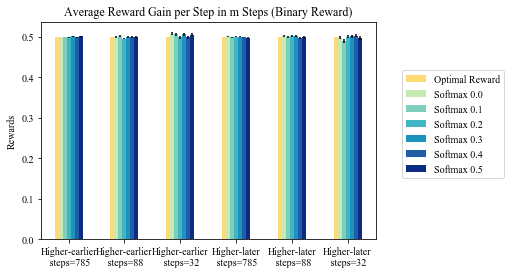

In [28]:
ax = plot_avg_reward_gain_at_m_single(BINARY, stdError=True)

### Normal Rewards

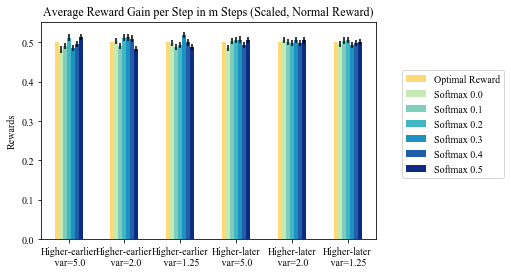

In [29]:
ax = plot_avg_reward_gain_at_m_single(NORMAL, stdError=True)

### Combine Plots

In [17]:
def plot_avg_reward_gain_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
        ns = nsB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
        ns = nsN
    for i in range(len(prefer_infix_lst)):
        for s in ns:
            df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], s, reward_type, "total_reward", stdError=stdError).iloc[1:2]
            if reward_type == BINARY:
                df_m["Optimal Reward"] = get_same_arm(softmaxRange[0], reward_type)
            else:
                arm = get_same_arm(softmaxRange[0], reward_type)
                df_m["Optimal Reward"] = scale_normal_rewards(arm, arm)


            df_m["or_std"] = pd.Series()

            df = pd.concat([df, df_m])

    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors)

    ax.set_xlabel("")
    if reward_type == BINARY:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n steps="+str(y), ns))+\
                           list(map(lambda y:preference_label[1]+"\n steps="+str(y), ns)))
    elif reward_type == NORMAL:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n var="+variancesN[str(y)], ns))+\
                           list(map(lambda y:preference_label[1]+"\n var="+variancesN[str(y)], ns)))
    ax.set_ylabel(ylabel)
    
    if hasLegend:
        ax.legend(bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Binary Reward")
    elif reward_type == NORMAL:
        ax.set_title("Scaled, Normal Reward")
    return ax

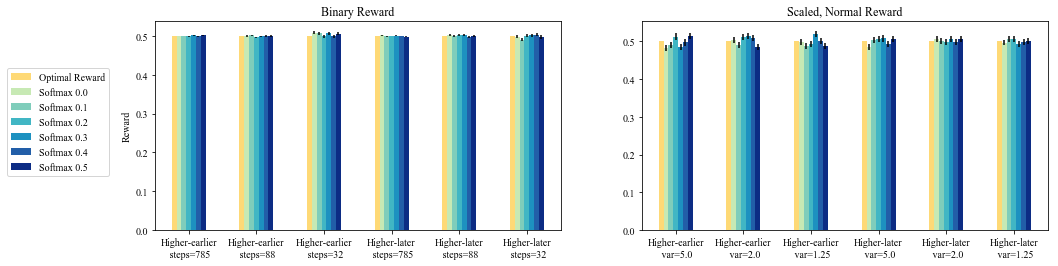

In [31]:
figure = plt.figure(figsize = (16, 4))
stdError = True

# Bar for Binary Reward 
ax = figure.add_subplot(1, 2, 1)
plot_avg_reward_gain_at_m(BINARY, ax, ylabel="Reward", legend_anchor=(-0.1, 0.8), stdError=stdError)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 2, 2)
plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

# Set super title for all subgraphs
plt.subplots_adjust(top=0.85)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgRewardGainPerStep.pdf', bbox_inches='tight')

# Power

In [10]:
def get_power_by_steps(dfs_by_trial, columns, alpha = 0.05):
    '''
    df_by_trial is a data frame with information about each run,
    as calculated by calculate_by_trial_statistics_from_sims.
    This function returns the continuous evaluation of power at every step until 4m steps,
    and the power snapshot at step 0.5m, m, 2m and 4m for all effect sizes.
    Power is calculated as what proportion of the p-values were below alpha at that point.
    '''
    unique_sample_sizes = dfs_by_trial[0].num_steps.unique()

    power_df = pd.DataFrame(columns=columns)
    power_all_steps = []
    for i in range(len(unique_sample_sizes)):
        cur_n = unique_sample_sizes[i]
        power_df.loc[i,columns[0]] = cur_n
        # Add bandit and uniform sampling lines 
        j = 1
        for df in dfs_by_trial:
            cur_df = df[df['num_steps'] == cur_n]
            statistic_list = []
            for trial in range(10, cur_n):
                avg_stat = np.sum(cur_df[cur_df['trial'] == trial]['pvalue'] < alpha) \
                            / len(cur_df[cur_df['trial'] == trial])
                statistic_list.append(avg_stat)
            
            if cur_n == unique_sample_sizes[-1]:
                power_all_steps.append(statistic_list[:])
            
            power_df.iloc[i, j] = statistic_list[-1]
            j+=1
    return power_all_steps, power_df

In [11]:
def plot_power_bar(df, x_col, y_col, ax, setLegend, title, legend_anchor=(0.5, 1.7), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]

    y.plot.bar(ax=ax, rot=0, color=color[1:])
    plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

In [14]:
def plot_power_bar_condensed(df, x_col, y_col, ax, setLegend, title, legend_anchor=(0.7, 1.5), ylabel="", \
                   hline_value=None, hline_label=None, color=colors, includeYLabel=False, legend_labels = None):
    print('df',df)
    x = df[x_col]
    y = df[y_col]
    print('x_col',x_col)
    print('y',y)
    
    df.plot.bar(y=y_col, ax=ax, rot=0, color=color[1:])
#     plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    plt.xlabel('')
    ax.set_xticklabels(['m','2m','m','2m'])
    print('legend_labels:',legend_labels)
    if legend_labels != None:
        legend = legend_labels
    else:
        legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value,0,1, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title,y=title_amt_above_axis)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        ax.set_ylabel(ylabel, fontsize = ylabel_font_size)
    else:
        ax.legend_.remove()
    if includeYLabel:
        ax.set_ylabel(ylabel,fontsize=ylabel_font_size)

In [34]:
binary_power

[  num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
 0       393       0.096       0.096        0.04       0.044       0.024   
 1       785       0.134        0.07       0.062       0.036        0.04   
 2      1570       0.148       0.062       0.054       0.032       0.038   
 3      3140        0.11       0.052       0.026       0.036       0.026   
 
   Softmax 0.5  
 0        0.03  
 1       0.026  
 2       0.038  
 3       0.022  ,
   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
 0       393       0.132       0.182        0.35        0.49       0.746   
 1       785       0.114       0.268       0.548       0.778       0.874   
 2      1570       0.122       0.376       0.724       0.932       0.966   
 3      3140       0.136       0.556       0.902       0.988       0.996   
 
   Softmax 0.5  
 0        0.83  
 1        0.94  
 2       0.994  
 3           1  ]

In [12]:
def make_combined_df_power_condensed(power_list):
    new_df = pd.DataFrame(columns=power_list[0].columns)
    for i in range(len(prefer_infix_lst)):
        new_df = new_df.append(power_list[i][1:2],ignore_index=True)
        new_df = new_df.append(power_list[i][2:3],ignore_index=True)

#     for i in range(len(prefer_infix_lst)):
#         new_df = new_df.append(power_list[i][2:3],ignore_index=True)
    new_df['x_spacing'] = list(range(len(prefer_infix_lst))) + [num+len(prefer_infix_lst)+ 4 for num in range(len(prefer_infix_lst))]
    return new_df

### Binary Reward

In [18]:
if not use_pickle:
    binary_power = []
    binary_power_all_steps = []
    effect_size = str(effectSizeB)
    prefix = bb_prefix
    infix = bb_infix
    ns = str(nsB[0])

    for i in range(len(prefer_infix_lst)):
        df_lst = []
        columns = list(mean_names_lst)
        preference_infix = prefer_infix_lst[i]
        v = variancesB[preference_infix]

        for i in range(len(softmaxRange)):
            softmax = softmaxRange[i]
            df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+byTrial_suffix)
            df_lst.append(df)

        power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"] + list(mean_names_lst))
        binary_power.append(power_df)
        binary_power_all_steps.append(power_all_steps)

    import pickle
    with open(date_prefix+'ReorderedBinaryPowerTwoArmsSame.pkl', 'wb') as f:
        pickle.dump(binary_power, f)

    with open(date_prefix+'ReorderedBinaryPowerAllStepsTwoArmsSame.pkl', 'wb') as f:
        pickle.dump(binary_power_all_steps, f)

In [11]:
if use_pickle:
    # Load from pickle
    import pickle
    binary_power = pd.read_pickle(date_prefix+'ReorderedBinaryPowerTwoArmsSame.pkl')
    binary_power_all_steps = pd.read_pickle(date_prefix+'ReorderedBinaryPowerAllStepsTwoArmsSame.pkl')

In [18]:
binary_power

[  num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
 0       393       0.096       0.096        0.04       0.044       0.024   
 1       785       0.134        0.07       0.062       0.036        0.04   
 2      1570       0.148       0.062       0.054       0.032       0.038   
 3      3140        0.11       0.052       0.026       0.036       0.026   
 
   Softmax 0.5  
 0        0.03  
 1       0.026  
 2       0.038  
 3       0.022  ,
   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
 0       393       0.132       0.182        0.35        0.49       0.746   
 1       785       0.114       0.268       0.548       0.778       0.874   
 2      1570       0.122       0.376       0.724       0.932       0.966   
 3      3140       0.136       0.556       0.902       0.988       0.996   
 
   Softmax 0.5  
 0        0.83  
 1        0.94  
 2       0.994  
 3           1  ]

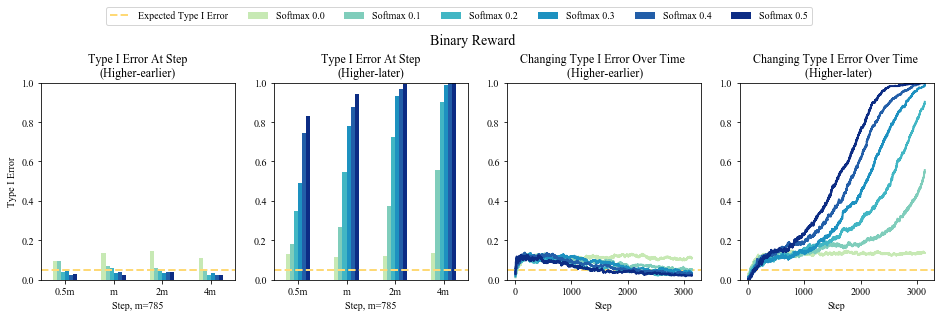

In [23]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Bar graph for power at step m
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)

    avg_power_binary = binary_power[i]
    plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error At Step\n("+preference_label[i]+")",\
                   legend_anchor=(4, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
    setLegend = False
    
# Line graph for power per step
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
    ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
    j = 1
    all_steps = binary_power_all_steps[i]
    for p in all_steps:
        x = range(10, len(p)+10)
        ax.plot(x, p, lw=2, color=colors[j])
        j+=1
    ax.set_xlabel('Step')
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    plt.title("Changing Type I Error Over Time \n ("+preference_label[i]+")")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredTypeIErrorPerStepBinary.pdf', bbox_inches='tight')

df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0       785       0.134        0.07       0.062       0.036        0.04   
1      1570       0.148       0.062       0.054       0.032       0.038   
2       785       0.114       0.268       0.548       0.778       0.874   
3      1570       0.122       0.376       0.724       0.932       0.966   

  Softmax 0.5  x_spacing  
0       0.026          0  
1       0.038          1  
2        0.94          6  
3       0.994          7  
x_col ['num_steps']
y   Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4 Softmax 0.5
0       0.134        0.07       0.062       0.036        0.04       0.026
1       0.148       0.062       0.054       0.032       0.038       0.038
2       0.114       0.268       0.548       0.778       0.874        0.94
3       0.122       0.376       0.724       0.932       0.966       0.994


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


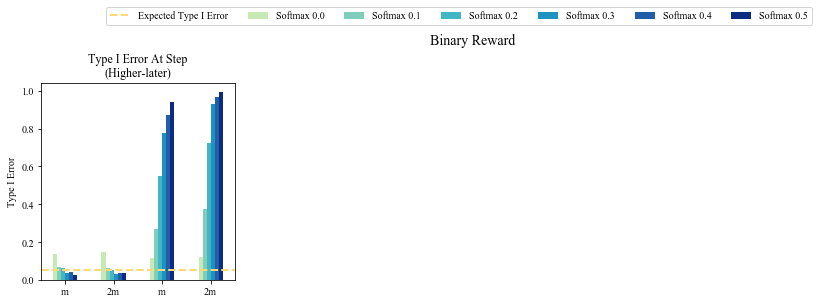

### Normal Reward

In [20]:
if not use_pickle:
    normal_power_vars = []
    normal_power_all_steps_vars = []
    for ns in nsN:            
        v = variancesN[str(ns)]
        normal_power = []
        normal_power_all_steps = []
        effect_size = str(effectSizeN)
        prefix = ng_prefix
        infix = ng_infix

        for i in range(len(prefer_infix_lst)):
            df_lst = []
            columns = list(mean_names_lst)
            preference_infix = prefer_infix_lst[i]

            for i in range(len(softmaxRange)):
                softmax = softmaxRange[i]
                df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+var_infix+v+byTrial_suffix)
                df_lst.append(df)

            power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"]+list(mean_names_lst))
            normal_power.append(power_df)
            normal_power_all_steps.append(power_all_steps)

        normal_power_vars.append(normal_power)
        normal_power_all_steps_vars.append(normal_power_all_steps)
    import pickle
    with open(date_prefix+'ReorderedNormalPowerTwoArmsSame.pkl', 'wb') as f:
        pickle.dump(normal_power_vars, f)

    with open(date_prefix+'ReorderedNormalPowerAllStepsTwoArmsSame.pkl', 'wb') as f:
        pickle.dump(normal_power_all_steps_vars, f)

In [16]:
if use_pickle:
    # Load from pickle
    import pickle
    normal_power_vars = pd.read_pickle(date_prefix+'ReorderedNormalPowerTwoArmsSame.pkl')
    normal_power_all_steps_vars = pd.read_pickle(date_prefix+'ReorderedNormalPowerAllStepsTwoArmsSame.pkl')

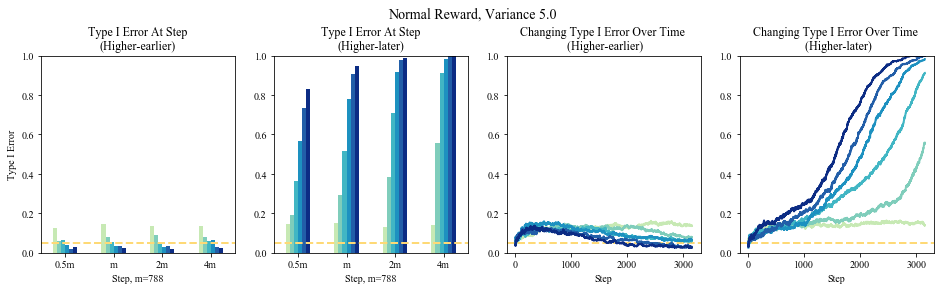

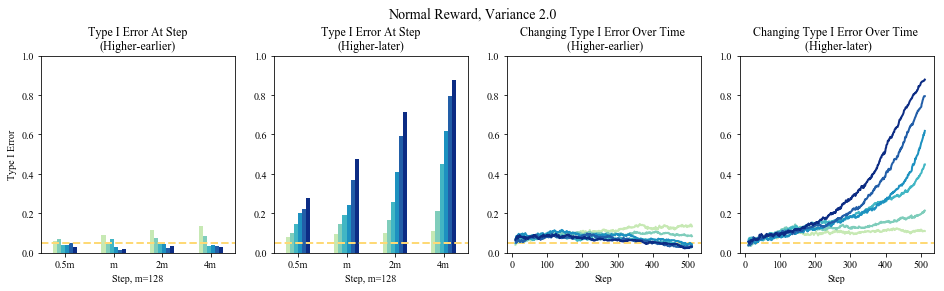

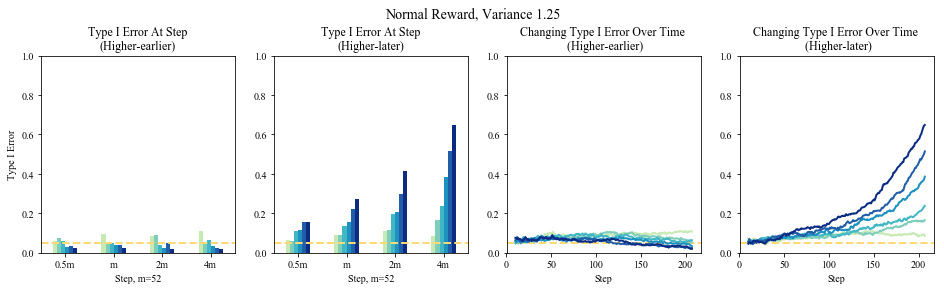

In [17]:
for foo in range(len(nsN)):
    normal_power = normal_power_vars[foo]
    normal_power_all_steps = normal_power_all_steps_vars[foo]
    
    figure = plt.figure(figsize = (16, 4))
    setLegend = False
    # Bar graph for power at step m
    for i in range(len(prefer_infix_lst)):
        ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)
        if (i == 0):
            ax.set_ylabel("Type I Error")
        avg_power_normal = normal_power[i]
        plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                       "Type I Error At Step\n("+preference_label[i]+")", \
                       ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")

    # Line graph for power per step
    for i in range(len(prefer_infix_lst)):
        ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
        ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
        j = 1
        all_steps = normal_power_all_steps[i]
        for p in all_steps:
            x = range(10, len(p)+10)
            ax.plot(x, p, lw=2, color=colors[j])
            j+=1
        ax.set_xlabel('Step')
        # set visualization range to 0-1
        ax.set_ylim(0.0, 1.0)
    
        plt.title("Changing Type I Error Over Time \n ("+preference_label[i]+")")

    figure.suptitle("Normal Reward, Variance "+variancesN[str(nsN[foo])],  fontsize=14)
    plt.subplots_adjust(top=0.81)
    figure.savefig(outdir_prefix+date_prefix+'Var'+variancesN[str(nsN[foo])]+'MeasuredTypeIErrorPerStepNormal.pdf', bbox_inches='tight')

In [44]:
def plot_worse_arm_estimate_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), color=colors, stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
#     for i in range(len(prefer_infix_lst)):
#         df_m = get_avg_col_per_num_steps_dfs(prefer_infix_lst[i], reward_type, 'mean_2', stdError).iloc[1:2]
#         if reward_type == BINARY:
#             actual_reward = min(get_arms(softmaxRange[0], reward_type))
#         else:
#             good_arm = max(get_arms(softmaxRange[0], reward_type))
#             bad_arm = min(get_arms(softmaxRange[0], reward_type))
#             actual_reward = scale_normal_rewards(bad_arm, good_arm, bad_arm)

#         df_m["or_std"] = pd.Series()

#         df = pd.concat([df, df_m])
#     import pickle
#     if reward_type == BINARY:
#         with open(date_prefix+'BinaryWorseArmEstimate.pkl', 'wb') as f:
#             pickle.dump(df, f)
#     elif reward_type == NORMAL:
#         with open(date_prefix+'NormalWorseArmEstimate.pkl', 'wb') as f:
#             pickle.dump(df, f)
    import pickle
    if reward_type == BINARY:
        actual_reward = 0.35
        df = pd.read_pickle('180120'+'BinaryWorseArmEstimate.pkl')
    elif reward_type == NORMAL:
        actual_reward = -0.5
        df = pd.read_pickle('180120'+'NormalWorseArmEstimate.pkl')
    m = df[list(mean_names_lst)]
    std = df[list(std_names_lst)]
    std.columns = list(mean_names_lst)
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors[1:])
    ax.axhline(actual_reward, color=color[0], linestyle='dashed', linewidth=2)
    
    legend = list(mean_names_lst)
    legend.insert(0, "Actual Reward")

    
    ax.set_xlabel("")
    ax.set_xticklabels(preference_label_two_lines)
    ax.set_ylabel(ylabel, fontsize=ylabel_font_size)
    
    if hasLegend:
        ax.legend(legend, bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()
    title = "Measured Condition Mean"
    if reward_type == BINARY:
        ax.set_title(title +"\n(Binary Reward)", y=title_amt_above_axis)
    elif reward_type == NORMAL:
        ax.set_title(title +"\n(Normally Dist. Reward)", y=title_amt_above_axis)
    return ax

df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0       785       0.134        0.07       0.062       0.036        0.04   
1      1570       0.148       0.062       0.054       0.032       0.038   
2       785       0.114       0.268       0.548       0.778       0.874   
3      1570       0.122       0.376       0.724       0.932       0.966   

  Softmax 0.5  x_spacing  
0       0.026          0  
1       0.038          1  
2        0.94          6  
3       0.994          7  
x_col ['num_steps']
y   Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4 Softmax 0.5
0       0.134        0.07       0.062       0.036        0.04       0.026
1       0.148       0.062       0.054       0.032       0.038       0.038
2       0.114       0.268       0.548       0.778       0.874        0.94
3       0.122       0.376       0.724       0.932       0.966       0.994
df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0       128     

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


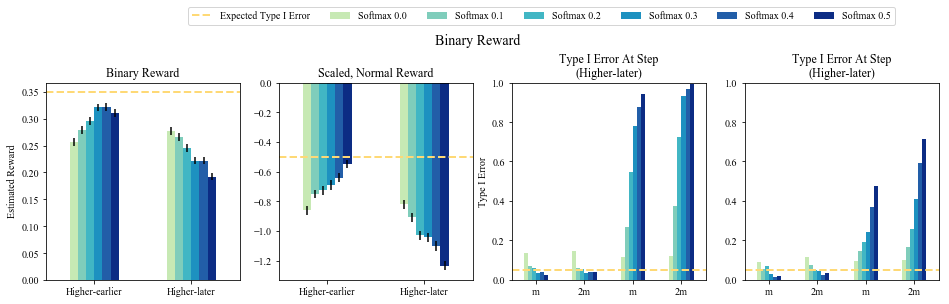

In [49]:
figure = plt.figure(figsize = (16, 4))

# First putting in the arm measurement figures when arms are different
stdError = True

# Bar for Binary Reward 
ax = figure.add_subplot(1, 4, 1)
plot_worse_arm_estimate_at_m(BINARY, ax, hasLegend=False, ylabel="Estimated Reward", legend_anchor=(-0.1, 0.8), stdError=stdError)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 4, 2)
plot_worse_arm_estimate_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)


setLegend = True

binary_power_df_condensed = make_combined_df_power_condensed(binary_power)
ax = figure.add_subplot(1, 4, 3)
plot_power_bar_condensed(binary_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error At Step\n("+preference_label[i]+")",\
                   legend_anchor=(2, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)
setLegend = False

normal_power_df_condensed = make_combined_df_power_condensed(normal_power_vars[1])
ax = figure.add_subplot(1, 4, 4)
plot_power_bar_condensed(normal_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error At Step\n("+preference_label[i]+")",\
                   legend_anchor=(4, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)
# # Bar graph for power at step m
# for i in range(len(prefer_infix_lst)):
#     ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)

#     avg_power_binary = binary_power[i]
#     plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), ax, setLegend, \
#                    "Type I Error At Step\n("+preference_label[i]+")",\
#                    legend_anchor=(4, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
#     setLegend = False
    
# # Line graph for power per step
# for i in range(len(prefer_infix_lst)):
#     ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
#     ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
#     j = 1
#     all_steps = binary_power_all_steps[i]
#     for p in all_steps:
#         x = range(10, len(p)+10)
#         ax.plot(x, p, lw=2, color=colors[j])
#         j+=1
#     ax.set_xlabel('Step')
#     # set visualization range to 0-1
#     ax.set_ylim(0.0, 1.0)
    
#     plt.title("Changing Type I Error Over Time \n ("+preference_label[i]+")")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredTypeIErrorPerStepBinaryCondensed.pdf', bbox_inches='tight')

df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0        88       0.606       0.496       0.468       0.338       0.282   
1       176       0.798       0.698       0.596        0.48       0.416   
2        88        0.53       0.636       0.708         0.8       0.822   
3       176        0.78       0.852       0.898        0.92       0.958   

  Softmax 0.5  x_spacing  
0       0.314          0  
1        0.38          1  
2       0.866          6  
3       0.958          7  
x_col ['num_steps']
y   Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4 Softmax 0.5
0       0.606       0.496       0.468       0.338       0.282       0.314
1       0.798       0.698       0.596        0.48       0.416        0.38
2        0.53       0.636       0.708         0.8       0.822       0.866
3        0.78       0.852       0.898        0.92       0.958       0.958
df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0       128     

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


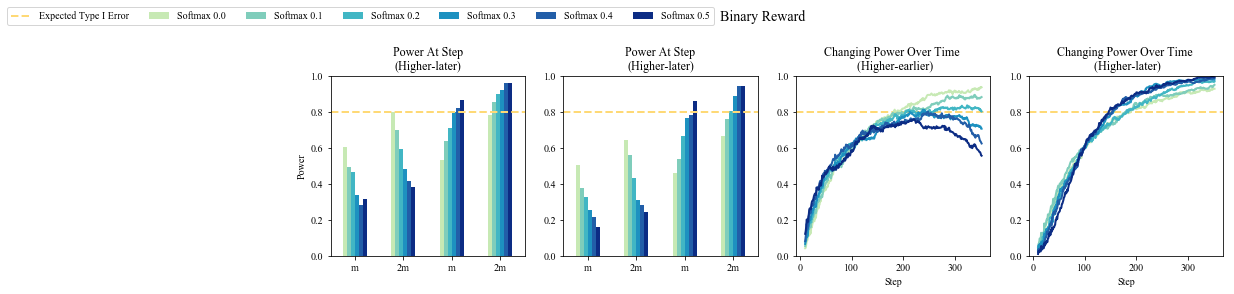

In [55]:
# Load from pickle
import pickle
date_prefix_differ = '180120'
binary_power_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedBinaryPowerTwoArmsDiffer.pkl')
binary_power_all_steps_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedBinaryPowerAllStepsTwoArmsDiffer.pkl')
normal_power_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedNormalPowerTwoArmsDiffer.pkl')
normal_power_all_steps_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedNormalPowerAllStepsTwoArmsDiffer.pkl')
figure = plt.figure(figsize = (16, 4))

setLegend = True

binary_power_df_condensed = make_combined_df_power_condensed(binary_power_arms_differ)
ax = figure.add_subplot(1, 4, 1)
plot_power_bar_condensed(binary_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power At Step\n("+preference_label[i]+")",\
                   legend_anchor=(2, 1.41), ylabel="Power", hline_value=0.8, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)
setLegend = False

normal_power_df_condensed = make_combined_df_power_condensed(normal_power_arms_differ)
ax = figure.add_subplot(1, 4, 2)
plot_power_bar_condensed(normal_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power At Step\n("+preference_label[i]+")",\
                   legend_anchor=(4, 1.41), ylabel="Power", hline_value=0.8, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)
# setLegend = True
# # Bar graph for power at step m
# for i in range(len(prefer_infix_lst)):
#     ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)

#     avg_power_binary = binary_power[i]
#     plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), ax, setLegend, \
#                    "Power At Step\n("+preference_label[i]+")",\
#                    legend_anchor=(1.6, 1.5), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
#     setLegend = False
    
# Line graph for power per step
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
    ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
    j = 1
    all_steps = binary_power_all_steps[i]
    for p in all_steps:
        x = range(10, len(p)+10)
        ax.plot(x, p, lw=2, color=colors[j])
        j+=1
    ax.set_xlabel('Step')
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    plt.title("Changing Power Over Time \n ("+preference_label[i]+")")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.75)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')

df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0        88       0.606       0.496       0.468       0.338       0.282   
1       176       0.798       0.698       0.596        0.48       0.416   
2        88        0.53       0.636       0.708         0.8       0.822   
3       176        0.78       0.852       0.898        0.92       0.958   

  Softmax 0.5  x_spacing  
0       0.314          0  
1        0.38          1  
2       0.866          6  
3       0.958          7  
x_col ['num_steps']
y   Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4 Softmax 0.5
0       0.606       0.496       0.468       0.338       0.282       0.314
1       0.798       0.698       0.596        0.48       0.416        0.38
2        0.53       0.636       0.708         0.8       0.822       0.866
3        0.78       0.852       0.898        0.92       0.958       0.958
legend_labels: ['$\\beta$ = 0.0', '$\\beta$ = 0.1', '$\\beta$ = 0.2', '$\\beta$ = 0.3', '$\\be

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


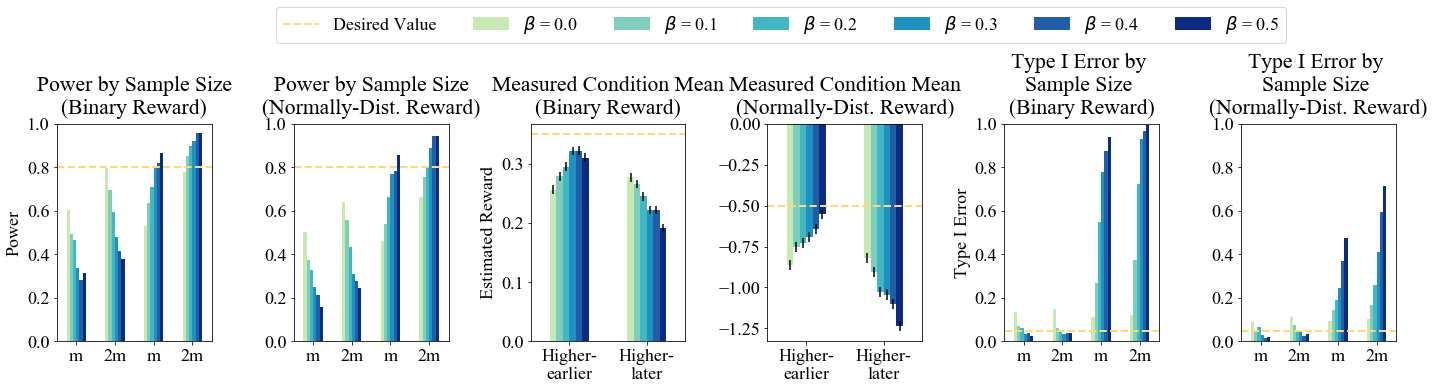

In [19]:
# Load from pickle
import pickle
date_prefix_differ = '180120'
binary_power_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedBinaryPowerTwoArmsDiffer.pkl')
binary_power_all_steps_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedBinaryPowerAllStepsTwoArmsDiffer.pkl')
normal_power_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedNormalPowerTwoArmsDiffer.pkl')
normal_power_all_steps_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedNormalPowerAllStepsTwoArmsDiffer.pkl')
figure = plt.figure(figsize = (24, 4))

setLegend = True
legend_labels = [r'$\beta$ = '+ str(round(0.1*i,1)) for i in range(0,6)]

binary_power_df_condensed = make_combined_df_power_condensed(binary_power_arms_differ)
ax = figure.add_subplot(1, 6, 1)
plot_power_bar_condensed(binary_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power by Sample Size\n(Binary Reward)",\
                   legend_anchor=(8, 1.58), ylabel="Power", \
                         hline_value=0.8, hline_label="Desired Value", legend_labels =legend_labels)
ax.set_ylim(0.0, 1.0)
setLegend = False

normal_power_df_condensed = make_combined_df_power_condensed(normal_power_arms_differ)
ax = figure.add_subplot(1, 6, 2)
plot_power_bar_condensed(normal_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power by Sample Size\n(Normally Dist. Reward)",\
                   legend_anchor=(4, 1.41), ylabel="Power", hline_value=0.8, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)

##### Arm measurement subplots
# First putting in the arm measurement figures when arms are different
stdError = True

# Bar for Binary Reward 
ax = figure.add_subplot(1, 6, 3)
plot_worse_arm_estimate_at_m(BINARY, ax, hasLegend=False, ylabel="Estimated Reward", legend_anchor=(-0.1, 0.8), stdError=stdError)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 6, 4)
plot_worse_arm_estimate_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

##### Type I error subplots
# Load from pickle
import pickle
date_prefix_same = '1029'
binary_power_arms_same = pd.read_pickle(date_prefix_same+'ReorderedBinaryPowerTwoArmsSame.pkl')
binary_power_all_steps_arms_same = pd.read_pickle(date_prefix_same+'ReorderedBinaryPowerAllStepsTwoArmsSame.pkl')
normal_power_vars_arms_same = pd.read_pickle(date_prefix_same+'ReorderedNormalPowerTwoArmsSame.pkl')
normal_power_all_steps_vars_arms_same = pd.read_pickle(date_prefix_same+'ReorderedNormalPowerAllStepsTwoArmsSame.pkl')
# setLegend = True
binary_power_df_condensed = make_combined_df_power_condensed(binary_power_arms_same)
ax = figure.add_subplot(1, 6, 5)
plot_power_bar_condensed(binary_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error by \nSample Size \n(Binary Reward)",\
                   legend_anchor=(2, 1.41), ylabel="Type I Error", hline_value=0.05, \
                   hline_label="Expected Type I Error",includeYLabel=True)
ax.set_ylim(0.0, 1.0)
setLegend = False

normal_power_df_condensed = make_combined_df_power_condensed(normal_power_vars_arms_same[1])
ax = figure.add_subplot(1, 6, 6)
plot_power_bar_condensed(normal_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error by \nSample Size \n(Normally-Dist. Reward)",\
                   legend_anchor=(4, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)
figure.subplots_adjust(wspace=.53)
figure.savefig(outdir_prefix+date_prefix+'CombinedReorderedRewardsGraph.pdf', bbox_inches='tight')

In [41]:
def plot_avg_reward_gain_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), stdError=False, datePrefix=None):
    df = pd.DataFrame(dtype=float)
    import pickle
    if reward_type == BINARY:
        effectSize = effectSizeB
        df = pd.read_pickle(datePrefix + 'ReorderedBinaryRewardTwoArmsDiffer.pkl')
    elif reward_type == NORMAL:
        effectSize = effectSizeN
        df = pd.read_pickle(datePrefix + 'ReorderedNormalRewardTwoArmsDiffer.pkl')

#     for i in range(len(prefer_infix_lst)):
#         df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], reward_type, "total_reward", stdError=stdError).iloc[1:2]
#         if reward_type == BINARY:
#             df_m["Optimal Reward"] = max(get_arms(softmaxRange[0], reward_type))
#         else:
#             good_arm = max(get_arms(softmaxRange[0], reward_type))
#             bad_arm = min(get_arms(softmaxRange[0], reward_type))
#             df_m["Optimal Reward"] = scale_normal_rewards(good_arm, good_arm, bad_arm)

#         df_m["or_std"] = pd.Series()

#         df = pd.concat([df, df_m])

    m = df[list(mean_names_lst)]#df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)]#df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)#list(mean_names_lst)+['Optimal Reward']
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors[1:])#colors)

    ax.set_xlabel("")
    ax.set_xticklabels(preference_label_two_lines)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0.0, 1.0)
    if hasLegend:
        ax.legend(bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Binary Reward")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward\n(Normally Dist. Rewards,\nas proportion of optimal)",y=title_amt_above_axis)
    return ax

df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0       128       0.502       0.374       0.328       0.252       0.214   
1       256       0.642        0.56       0.434       0.312        0.28   
2       128       0.462       0.538       0.666       0.768       0.782   
3       256       0.666       0.758       0.804       0.888       0.944   

  Softmax 0.5  x_spacing  
0        0.16          0  
1       0.246          1  
2       0.858          6  
3       0.946          7  
x_col ['num_steps']
y   Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4 Softmax 0.5
0       0.502       0.374       0.328       0.252       0.214        0.16
1       0.642        0.56       0.434       0.312        0.28       0.246
2       0.462       0.538       0.666       0.768       0.782       0.858
3       0.666       0.758       0.804       0.888       0.944       0.946
legend_labels: ['$\\beta$ = 0.0', '$\\beta$ = 0.1', '$\\beta$ = 0.2', '$\\beta$ = 0.3', '$\\be

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


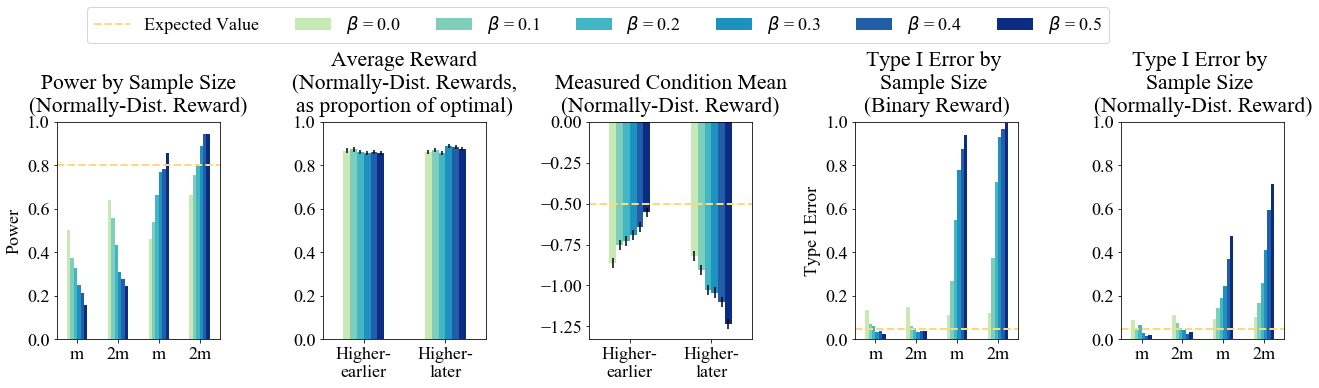

In [54]:
-

df   num_steps Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4  \
0       128       0.502       0.374       0.328       0.252       0.214   
1       256       0.642        0.56       0.434       0.312        0.28   
2       128       0.462       0.538       0.666       0.768       0.782   
3       256       0.666       0.758       0.804       0.888       0.944   

  Softmax 0.5  x_spacing  
0        0.16          0  
1       0.246          1  
2       0.858          6  
3       0.946          7  
x_col ['num_steps']
y   Softmax 0.0 Softmax 0.1 Softmax 0.2 Softmax 0.3 Softmax 0.4 Softmax 0.5
0       0.502       0.374       0.328       0.252       0.214        0.16
1       0.642        0.56       0.434       0.312        0.28       0.246
2       0.462       0.538       0.666       0.768       0.782       0.858
3       0.666       0.758       0.804       0.888       0.944       0.946
legend_labels: ['$\\beta$ = 0.0', '$\\beta$ = 0.1', '$\\beta$ = 0.2', '$\\beta$ = 0.3', '$\\be

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


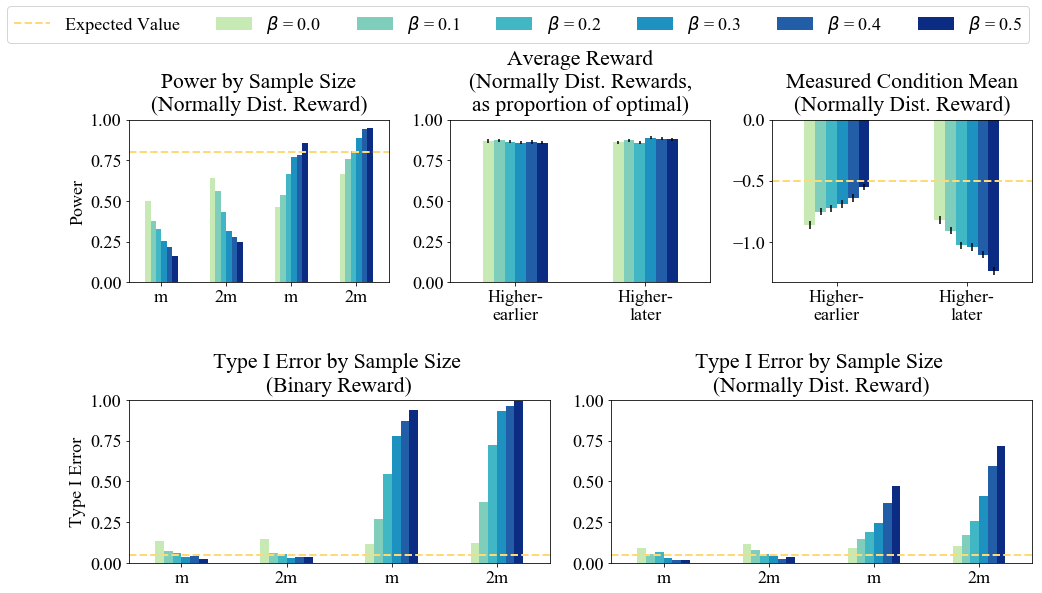

In [51]:
from matplotlib import gridspec
# Load from pickle
import pickle
date_prefix_differ = '180120'
binary_power_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedBinaryPowerTwoArmsDiffer.pkl')
binary_power_all_steps_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedBinaryPowerAllStepsTwoArmsDiffer.pkl')
normal_power_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedNormalPowerTwoArmsDiffer.pkl')
normal_power_all_steps_arms_differ = pd.read_pickle(date_prefix_differ+'ReorderedNormalPowerAllStepsTwoArmsDiffer.pkl')
figure = plt.figure(figsize = (14, 8))
gs = gridspec.GridSpec(2, 6) 
setLegend = True
legend_labels = [r'$\beta$ = '+ str(round(0.1*i,1)) for i in range(0,6)]

binary_power_df_condensed = make_combined_df_power_condensed(binary_power_arms_differ)
# ax = figure.add_subplot(1, 5, 1)
ax = figure.add_subplot(gs[0,0:2])

# plot_power_bar_condensed(binary_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
#                    "Power by Sample Size\n(Binary Reward)",\
#                    legend_anchor=(8, 1.58), ylabel="Power", \
#                          hline_value=0.8, hline_label="Desired Value", legend_labels =legend_labels)
# ax.set_ylim(0.0, 1.0)

normal_power_df_condensed = make_combined_df_power_condensed(normal_power_arms_differ)
# ax = figure.add_subplot(1, 6, 2)
plot_power_bar_condensed(normal_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Power by Sample Size\n(Normally Dist. Reward)",\
                   legend_anchor=(3.5, 1.75), ylabel="Power", hline_value=0.8, \
                         hline_label="Expected Value", legend_labels =legend_labels)
ax.set_ylim(0.0, 1.0)
setLegend = False

##### Reward subplot
stdError = True

# ax = figure.add_subplot(1, 5, 2)
ax = figure.add_subplot(gs[0,2:4])

plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False, stdError=stdError, datePrefix=date_prefix_differ)


##### Arm measurement subplots
# First putting in the arm measurement figures when arms are different

# # Bar for Binary Reward 
# ax = figure.add_subplot(1, 6, 3)
# plot_worse_arm_estimate_at_m(BINARY, ax, hasLegend=False, ylabel="Estimated Reward", legend_anchor=(-0.1, 0.8), stdError=stdError)

# Bar for Normal Reward 
# ax = figure.add_subplot(1, 5, 3)
ax = figure.add_subplot(gs[0,4:6])

plot_worse_arm_estimate_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

##### Type I error subplots
# Load from pickle
import pickle
date_prefix_same = '1029'
binary_power_arms_same = pd.read_pickle(date_prefix_same+'ReorderedBinaryPowerTwoArmsSame.pkl')
binary_power_all_steps_arms_same = pd.read_pickle(date_prefix_same+'ReorderedBinaryPowerAllStepsTwoArmsSame.pkl')
normal_power_vars_arms_same = pd.read_pickle(date_prefix_same+'ReorderedNormalPowerTwoArmsSame.pkl')
normal_power_all_steps_vars_arms_same = pd.read_pickle(date_prefix_same+'ReorderedNormalPowerAllStepsTwoArmsSame.pkl')
# setLegend = True
binary_power_df_condensed = make_combined_df_power_condensed(binary_power_arms_same)
# ax = figure.add_subplot(1, 5, 4)
ax = figure.add_subplot(gs[1,0:3])

plot_power_bar_condensed(binary_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error by Sample Size \n(Binary Reward)",\
                   legend_anchor=(1, 1.41), ylabel="Type I Error", hline_value=0.05, \
                   hline_label="Expected Type I Error",includeYLabel=True)
ax.set_ylim(0.0, 1.0)
setLegend = False

normal_power_df_condensed = make_combined_df_power_condensed(normal_power_vars_arms_same[1])
# ax = figure.add_subplot(1, 5, 5)
ax = figure.add_subplot(gs[1,3:6])

plot_power_bar_condensed(normal_power_df_condensed, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error by Sample Size \n(Normally Dist. Reward)",\
                   legend_anchor=(4, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
ax.set_ylim(0.0, 1.0)
figure.subplots_adjust(wspace=.8, hspace=.9)
figure.tight_layout(h_pad=1.5)
save_date_prefix = "190617"
figure.savefig(outdir_prefix+save_date_prefix+'CombinedReorderedRewardsGraph2.pdf', bbox_inches='tight')

In [55]:
import random
print("my random number",random.random())

my random number 0.8605711629038747
